X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).

X4: Marital status (1 = married; 2 = single; 3 = divorce; 0=others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. 

The measurement scale for the repayment status is:
-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

Y: client's behavior; Y=0 then not default, Y=1 then default"


In [44]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
%matplotlib inline 

import gc

from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

pd.set_option('precision', 2)
pd.set_option('display.max_columns', 50)

In [45]:
# Import data

data = pd.read_csv("default of credit card clients.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
# Check data

data.info()
# 30000 rows and 25columns without missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [59]:
# drop column "ID"

data.drop('ID', axis = 1, inplace =True) 

In [34]:
# Variable 'EDUCATION': group the categories 0, 4, 5, 6 into a single class '0' (others)

data['EDUCATION']=np.where(data['EDUCATION'] == 4, 0, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 5, 0, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 6, 0, data['EDUCATION'])

In [60]:
# Variables description

data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,3.00e+04,30000.00,30000.00,30000.00,30000.00,3.00e+04,30000.00,30000.00,30000.00,30000.00,30000.00
mean,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,-0.29,51223.33,49179.08,4.70e+04,43262.95,40311.40,38871.76,5663.58,5.92e+03,5225.68,4826.08,4799.39,5215.50,0.22
std,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,1.15,73635.86,71173.77,6.93e+04,64332.86,60797.16,59554.11,16563.28,2.30e+04,17606.96,15666.16,15278.31,17777.47,0.42
min,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-165580.00,-69777.00,-1.57e+05,-170000.00,-81334.00,-339603.00,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00
25%,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,3558.75,2984.75,2.67e+03,2326.75,1763.00,1256.00,1000.00,8.33e+02,390.00,296.00,252.50,117.75,0.00
50%,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,22381.50,21200.00,2.01e+04,19052.00,18104.50,17071.00,2100.00,2.01e+03,1800.00,1500.00,1500.00,1500.00,0.00
75%,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,0.00,67091.00,64006.25,6.02e+04,54506.00,50190.50,49198.25,5006.00,5.00e+03,4505.00,4013.25,4031.50,4000.00,0.00
max,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,8.00,964511.00,983931.00,1.66e+06,891586.00,927171.00,961664.00,873552.00,1.68e+06,896040.00,621000.00,426529.00,528666.00,1.00


There are 30,000 distinct credit card clients.

The average value for the amount of credit card limit is 167,484 with max value being 1M.

More than half of those clients graduating from university or graduate school.

Most of the clients are either marrined or single.

The average age is 35.

## Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Default Credit Card Clients - Default Payment Next Month')

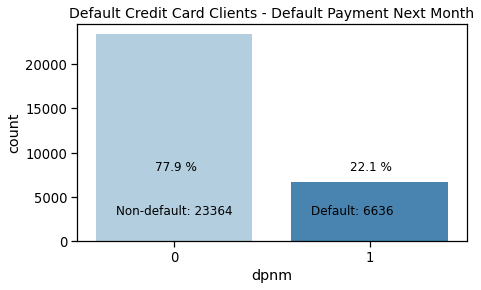

In [57]:
# The frequency of defaults
yes = data.dpnm.sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(data)*100, 1)
no_perc = round(no/len(data)*100, 1)

plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('dpnm',data=data, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('Default Credit Card Clients - Default Payment Next Month', size=14)

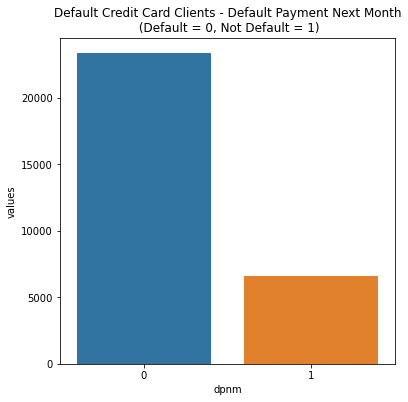

In [24]:
# Plot of target value

temp = data["dpnm"].value_counts()
df = pd.DataFrame({'dpnm': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - Default Payment Next Month\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = "dpnm", y="values", data=df)
locs, labels = plt.xticks()
plt.show()

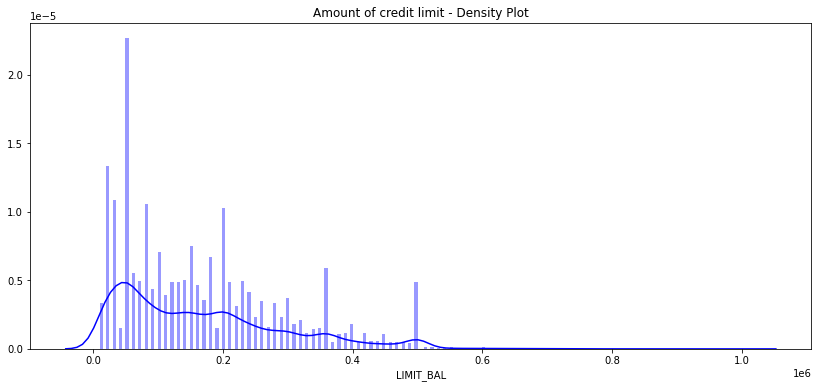

In [26]:
# Amount of credit limit

plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data["LIMIT_BAL"],kde=True,bins=200, color="blue")
plt.show()


In [27]:
# Largest group of amount of credit limit is for amount of 50K (3365 clients)

data['LIMIT_BAL'].value_counts().head(5)

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: LIMIT_BAL, dtype: int64

Text(0.5, 1.0, 'Credit Limit Histogram by Default Payment Next Month')

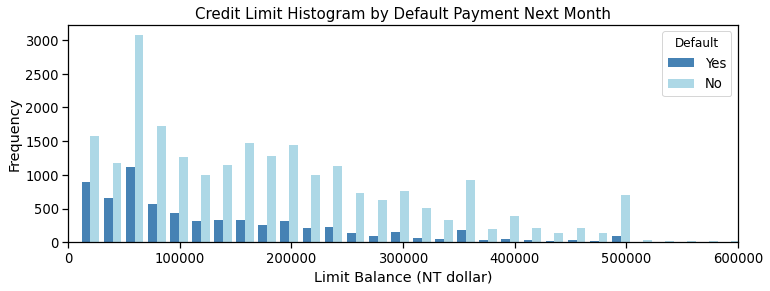

In [56]:
#Frequency of limit balance by default payment next month

x1 = list(data[data['dpnm'] == 1]['LIMIT_BAL'])
x2 = list(data[data['dpnm'] == 0]['LIMIT_BAL'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 50, density=False, color=['steelblue', 'lightblue'])
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('Limit Balance Histogram by Default Payment Next Month', SIZE=15)

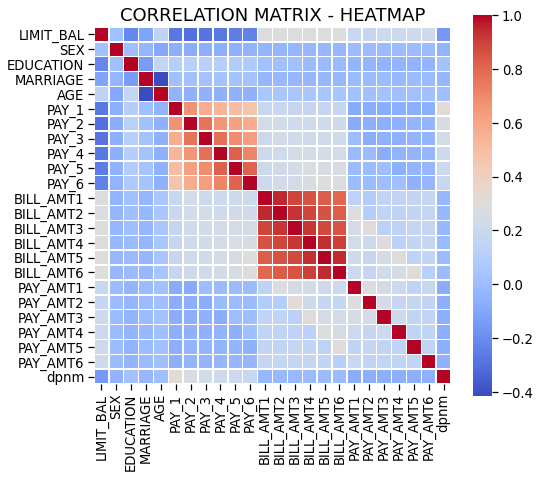

In [61]:
# Features correlation
corr = data.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

The variable "AGE" are highly correlated with "MARIAGE".

The only feature with a notable positive correlation with the dependent variable ‘dpnm’ is repayment status during the last month (September). 

The highest negative correlation with default occurs with Limit_Balance, indicating that customers with lower limit balance are more likely to default.

## Predictive Models

In [ ]:
# Split the data into train and test sets